This code will load the model information, generate the model definition, and run the model estimation using FSL

In [21]:
import nipype.algorithms.modelgen as model   # model generation
from  nipype.interfaces import fsl, ants      
from nipype.interfaces.base import Bunch
import os,json,glob
import numpy
import nibabel
import nilearn.plotting

from make_event_files_from_json import MakeEventFilesFromJSON
%matplotlib inline
import matplotlib.pyplot as plt


try:
    datadir=os.environ['FMRIDATADIR']
    assert not datadir==''
except:
    datadir='/Users/poldrack/data_unsynced/myconnectome/sub00001'
    
results_dir = os.path.abspath("../results")
if not os.path.exists(results_dir):
    os.mkdir(results_dir)

from nipype.caching import Memory
mem = Memory(base_dir='.')

print 'Using data from',datadir

Using data from /home/vagrant/data


Load the scan and model info, and generate the event files for FSL from the information in model.json

In [22]:
subject='sub00001'
session='ses014'  
# note - we have to use the anatomy from a different session'
subdir=os.path.join(datadir,'ds031', subject, session)
tasknum=2 # n-back

preprocessed_epi = os.path.join(results_dir, "preprocessed_epi_native_space.nii.gz")

scaninfo=json.load(open(os.path.join(subdir,
        'functional/sub00001_ses014_task002_run001_bold.json')))
tr=scaninfo['RepetitionTime']

modelfile=os.path.join(subdir,'model.json')
modelinfo=json.load(open(modelfile))
taskinfo=modelinfo['task%03d'%tasknum]['model001']
evs=taskinfo['Variables']
contrasts=taskinfo['Contrasts']

# get the response onsets
response_onsets=[]

for v in evs.iterkeys():

    if evs[v]['VariableName'].find('_target_ons')>-1:
        for ons in evs[v]['onsets']:
            response_onsets.append(ons[0])

Specify the model.  For the sake of speed we will use a simplified model that treats the study as a blocked design rather than modeling each item separately, but we also model instructions and motor responses; this, it is a hybrid block/event-related design

In [23]:
instruction_onsets=list(numpy.array([68,176,372,2,154,416,24,220,350,112,198,328,46,264,394,90,242,306])-2.0)

info = [Bunch(conditions=['faces-1back',
                          'faces-2back',
                          'scenes-1back',
                          'scenes-2back',
                          'chars-1back',
                          'chars-2back',
                          'instructions',
                          'responses'],
              onsets=[[68,176,372],
                      [2,154,416],
                      [24,220,350],
                      [112,198,328],
                      [46,264,394],
                      [90,242,306],
                      instruction_onsets,
                      response_onsets],
              durations=[[20],
                         [20],
                         [20],
                         [20],
                         [20],
                         [20],
                         [2],
                         [1]])
       ]

s = model.SpecifyModel()
s.inputs.input_units = 'secs'
s.inputs.functional_runs = preprocessed_epi
s.inputs.time_repetition = 6
s.inputs.high_pass_filter_cutoff = 128.
s.inputs.subject_info = info
specify_model_results = s.run()

Generate the fsf and ev files using Level1Design

In [24]:
contrasts=[['faces>Baseline','T', 
            ['faces-1back','faces-2back'],[0.5,0.5]],
           ['scenes>Baseline','T', 
            ['scenes-1back','scenes-2back'],[0.5,0.5]],
           ['chars>Baseline','T', 
            ['chars-1back','chars-2back'],[0.5,0.5]],
           ['2back>1back','T', 
            ['faces-1back','faces-2back','scenes-1back','scenes-2back','chars-1back','chars-2back'],[-1,1,-1,1,-1,1,-1,1]],
          ['response>Baseline','T',
           ['responses'],[1]],
          ['instructions>Baseline','T',
           ['instructions'],[1]]]
           
level1design = mem.cache(fsl.model.Level1Design)
level1design_results = level1design(interscan_interval = tr,
                                    bases = {'dgamma':{'derivs': True}},
                                    session_info = specify_model_results.outputs.session_info,
                                    model_serial_correlations=True,
                                    contrasts=contrasts)

level1design_results.outputs

INFO:workflow:Executing node fd0e4b41992c6422157c4efe0fbf2570 in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-Level1Design/fd0e4b41992c6422157c4efe0fbf2570
INFO:workflow:Collecting precomputed outputs



ev_files = ['/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-Level1Design/fd0e4b41992c6422157c4efe0fbf2570/ev_faces-1back_0_1.txt', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-Level1Design/fd0e4b41992c6422157c4efe0fbf2570/ev_faces-2back_0_3.txt', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-Level1Design/fd0e4b41992c6422157c4efe0fbf2570/ev_scenes-1back_0_5.txt', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-Level1Design/fd0e4b41992c6422157c4efe0fbf2570/ev_scenes-2back_0_7.txt', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-Level1Design/fd0e4b41992c6422157c4efe0fbf2570/ev_chars-1back_0_9.txt', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-Level1Design/fd0e4b41992c6422157c4efe0fbf2570/ev_chars-2back_0_11.txt', '/home/vagra

Generate the full set of model files using FEATModel

In [25]:
modelgen = mem.cache(fsl.model.FEATModel)
modelgen_results = modelgen(fsf_file=level1design_results.outputs.fsf_files,
                            ev_files=level1design_results.outputs.ev_files)
modelgen_results.outputs

INFO:workflow:Executing node e88c9cabfa8dd6a9d95fdc8320018009 in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FEATModel/e88c9cabfa8dd6a9d95fdc8320018009
INFO:workflow:Collecting precomputed outputs



con_file = /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FEATModel/e88c9cabfa8dd6a9d95fdc8320018009/run0.con
design_cov = /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FEATModel/e88c9cabfa8dd6a9d95fdc8320018009/run0_cov.png
design_file = /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FEATModel/e88c9cabfa8dd6a9d95fdc8320018009/run0.mat
design_image = /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FEATModel/e88c9cabfa8dd6a9d95fdc8320018009/run0.png
fcon_file = <undefined>

Visualize the design matrix

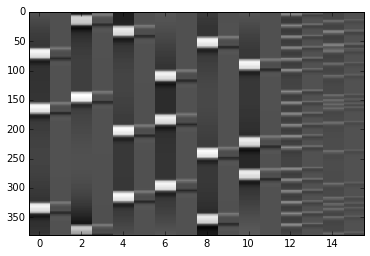

In [26]:
desmtx=numpy.loadtxt(modelgen_results.outputs.design_file,skiprows=5)
plt.imshow(desmtx,aspect='auto',interpolation='nearest',cmap='gray')

Show the correlation matrix for design

<matplotlib.colorbar.Colorbar instance at 0x7f8e1df4bef0>

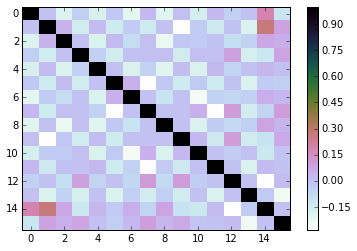

In [27]:
cc=numpy.corrcoef(desmtx.T)
plt.imshow(cc,aspect='auto',interpolation='nearest', cmap=plt.cm.cubehelix_r)
plt.colorbar()

Estimate the model using FILMGLS - this will take a few minutes.

In [28]:
mask = mem.cache(fsl.maths.ApplyMask)
mask_results = mask(in_file=preprocessed_epi,
                    mask_file=os.path.join(results_dir, "mask.nii.gz"))
mask_results.outputs

INFO:workflow:Executing node 5494d4441434d872f522138d66b31ca7 in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-maths-ApplyMask/5494d4441434d872f522138d66b31ca7
INFO:workflow:Collecting precomputed outputs



out_file = /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-maths-ApplyMask/5494d4441434d872f522138d66b31ca7/preprocessed_epi_native_space_masked.nii.gz

In [29]:
filmgls = mem.cache(fsl.FILMGLS)
filmgls_results = filmgls(in_file=mask_results.outputs.out_file,
                          design_file = modelgen_results.outputs.design_file,
                          tcon_file = modelgen_results.outputs.con_file,
                          autocorr_noestimate = True)
filmgls_results.outputs

INFO:workflow:Executing node 8c13877a8a70c6e3e8f92498f4ef0dd0 in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/8c13877a8a70c6e3e8f92498f4ef0dd0
INFO:workflow:Collecting precomputed outputs



copes = ['/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/8c13877a8a70c6e3e8f92498f4ef0dd0/results/cope1.nii.gz', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/8c13877a8a70c6e3e8f92498f4ef0dd0/results/cope2.nii.gz', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/8c13877a8a70c6e3e8f92498f4ef0dd0/results/cope3.nii.gz', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/8c13877a8a70c6e3e8f92498f4ef0dd0/results/cope4.nii.gz', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/8c13877a8a70c6e3e8f92498f4ef0dd0/results/cope5.nii.gz', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/8c13877a8a70c6e3e8f92498f4ef0dd0/results/cope6.nii.gz']
dof_file = /home/vagrant/fmri-analysis-vm/analysis/firstleve

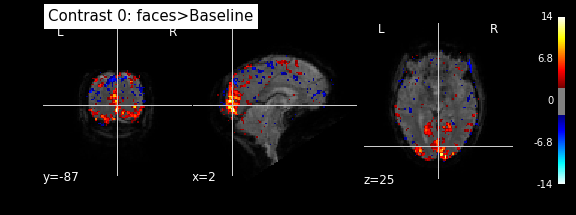

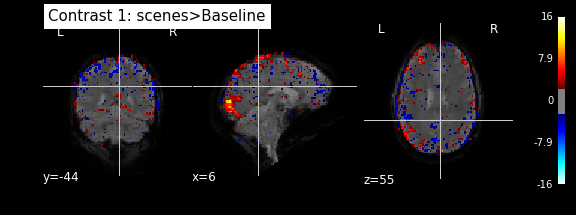

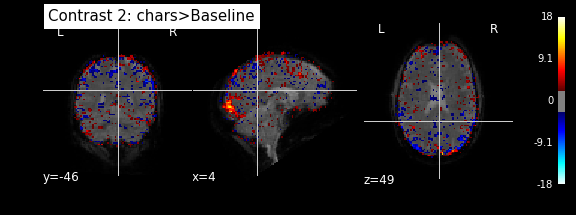

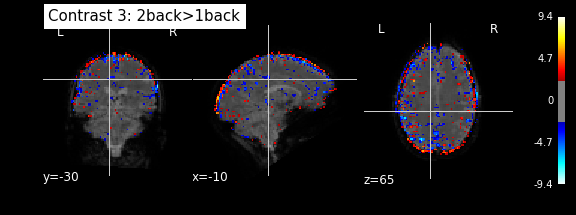

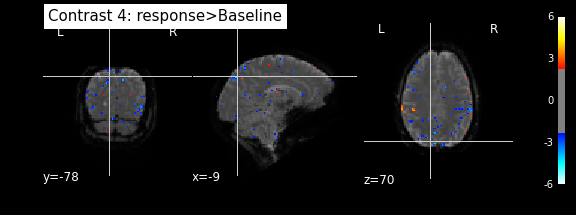

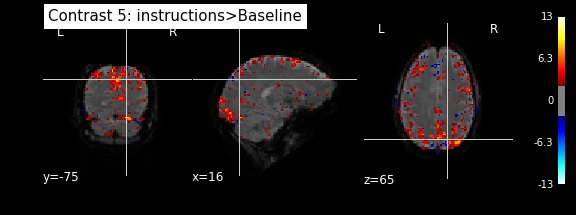

In [30]:
meanimg=nibabel.load(os.path.join(results_dir, "meanbold.nii.gz"))

for contrast_i in range(len(contrasts)):
    nilearn.plotting.plot_stat_map(filmgls_results.outputs.zstats[contrast_i], meanimg,
                                   title='Contrast %d: %s'%(contrast_i,contrasts[contrast_i][0]),
                                   threshold=2.3)

## Move copes, varcopes, and the mask into MNI space

For the group level analysis we need to move results from all subjects into one common MNI space. Let's start with the EPI derived mask (we will use it later for group level mask)

INFO:workflow:Executing node f97f696f5a5d858034121e987281bd3a in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-preprocess-ApplyWarp/f97f696f5a5d858034121e987281bd3a
INFO:workflow:Collecting precomputed outputs
INFO:workflow:Executing node 864cdeaa96c1590667c8e90f2fe3e79b in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-ants-resampling-ApplyTransforms/864cdeaa96c1590667c8e90f2fe3e79b
INFO:workflow:Running: antsApplyTransforms --default-value 0 --input /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-preprocess-ApplyWarp/f97f696f5a5d858034121e987281bd3a/mask_warp.nii.gz --interpolation NearestNeighbor --output mask_warp_trans.nii.gz --reference-image /usr/share/fsl/5.0/data/standard/MNI152_T1_2mm_brain.nii.gz --transform /home/vagrant/fmri-analysis-vm/analysis/results/t1_to_mni_warp.h5
INFO:interface:stdout 2015-08-13T17:55:00.475563:Using double precision for computations

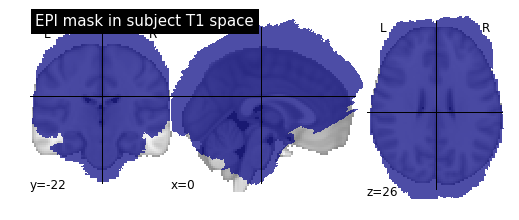

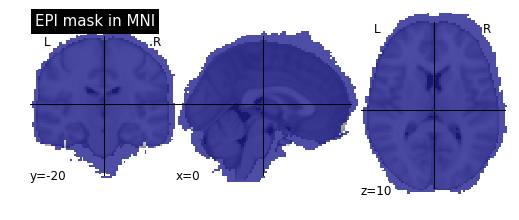

In [31]:
mask_file = os.path.join(results_dir, "mask.nii.gz")
epi_to_t1_warp = os.path.join(results_dir, "epi_to_t1_warp.nii.gz")
t1_to_mni_warp = os.path.join(results_dir, "t1_to_mni_warp.h5")
in_file = mask_file
anat_subject='ses018'
anatomydir=os.path.join(datadir,'ds031/sub00001',anat_subject,
        'anatomy')
t1_file = os.path.join(anatomydir,'sub00001_ses018_T1w_001.nii.gz')

epi_to_t1 = mem.cache(fsl.ApplyWarp)
epi_to_t1_mask_results = epi_to_t1(in_file=in_file,
                                   ref_file=t1_file,
                                   field_file=epi_to_t1_warp,
                                   interp="nn")
nilearn.plotting.plot_roi(epi_to_t1_mask_results.outputs.out_file, title="EPI mask in subject T1 space")

t1_to_mni = mem.cache(ants.ApplyTransforms)
t1_to_mni_mask_results = t1_to_mni(input_image=epi_to_t1_mask_results.outputs.out_file,
                                   reference_image=os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz'),
                                   transforms=t1_to_mni_warp,
                                   interpolation="NearestNeighbor")
t1_to_mni_mask_results.outputs
nilearn.plotting.plot_roi(t1_to_mni_mask_results.outputs.output_image, title="EPI mask in MNI")

Now we can use the same procedure for all of the contrast and variance images.

INFO:workflow:Executing node 91d7a4f53184571d8c7f65641ec48df1 in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-preprocess-ApplyWarp/91d7a4f53184571d8c7f65641ec48df1
INFO:workflow:Collecting precomputed outputs
INFO:workflow:Executing node b8ca724c35b5a0939e45daaa569cbd4f in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-ants-resampling-ApplyTransforms/b8ca724c35b5a0939e45daaa569cbd4f
INFO:workflow:Running: antsApplyTransforms --default-value 0 --input /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-preprocess-ApplyWarp/91d7a4f53184571d8c7f65641ec48df1/cope1_warp.nii.gz --interpolation BSpline --output cope1_warp_trans.nii.gz --reference-image /usr/share/fsl/5.0/data/standard/MNI152_T1_2mm_brain.nii.gz --transform /home/vagrant/fmri-analysis-vm/analysis/results/t1_to_mni_warp.h5
INFO:interface:stdout 2015-08-13T17:55:02.190931:Using double precision for computations.
INFO

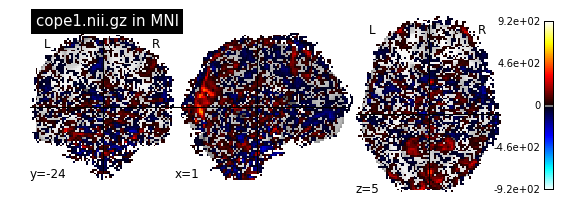

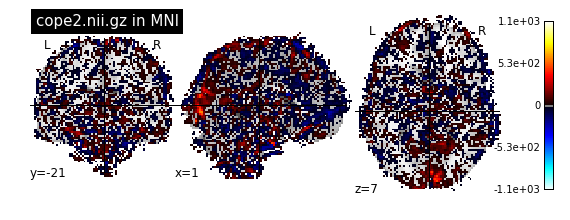

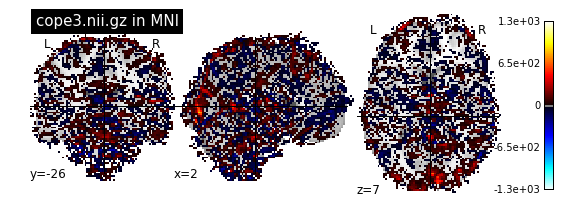

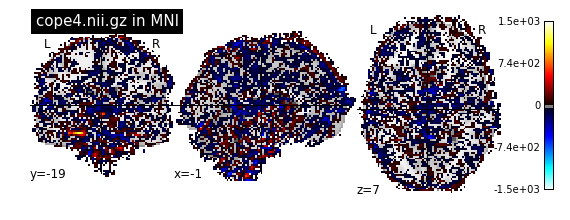

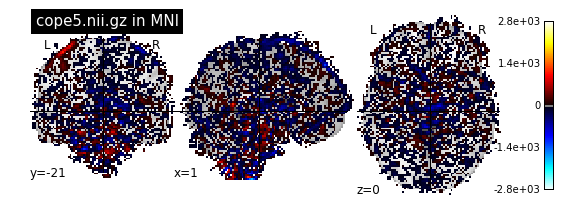

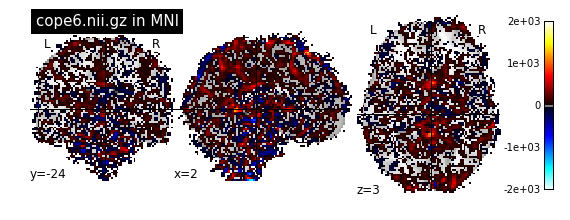

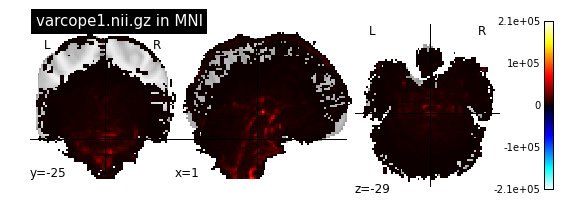

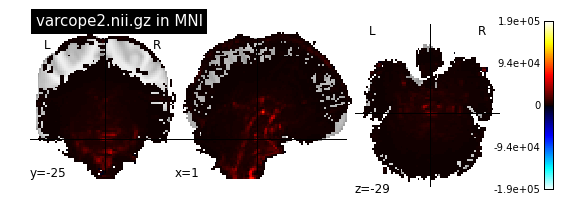

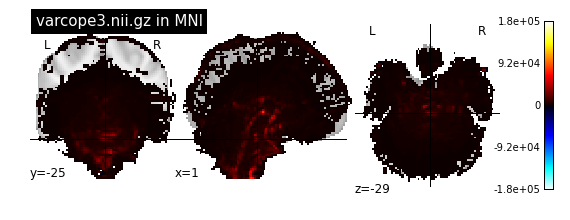

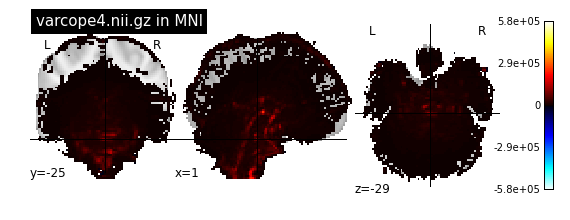

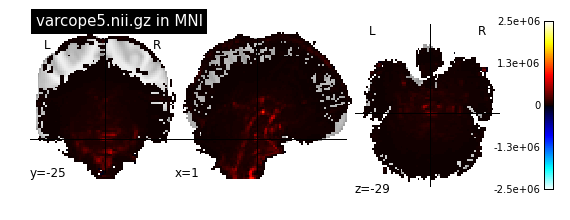

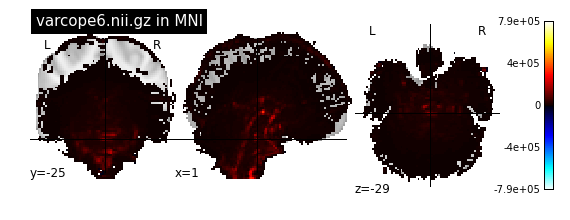

In [32]:
for image in filmgls_results.outputs.copes + filmgls_results.outputs.varcopes:
    _, fname = os.path.split(image)
    epi_to_t1_results = epi_to_t1(in_file=image,
                                       ref_file=t1_file,
                                       field_file=epi_to_t1_warp,
                                       interp="spline")

    t1_to_mni_results = t1_to_mni(input_image=epi_to_t1_results.outputs.out_file,
                                  reference_image=os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz'),
                                  transforms=t1_to_mni_warp,
                                  interpolation="BSpline")
    nilearn.plotting.plot_stat_map(t1_to_mni_results.outputs.output_image, title="%s in MNI"%fname, threshold='auto')